In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_spd_matrix
from scipy.special import softmax
from scipy.stats import multivariate_normal

In [2]:
data = np.load("dataset.npy")
data.shape

(300, 2)

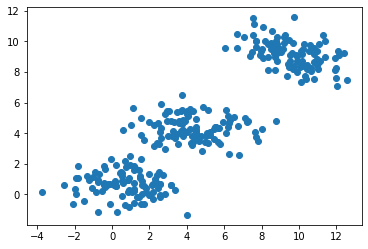

In [3]:
plt.scatter(data[:,0], data[:,1])
plt.show()

In [11]:
class ExpectationMaximization():
    """
    Implementation of expectation maximization algorithm.
    """
    def __init__(self, n_gaussian):
        """
        The algorithm is run for n gaussians
        After calling fit function:
            Model parameters are stored in the 'params' variable.
            Loglikelihood value is stored in the 'log_likelihood' variable.
            Gamma values for each datapoint is stored in the 'gamma values' variable
        """
        self.n_gaussian = n_gaussian
        self.params = None
        self.gamma_values = None
        self.log_likelihood = np.inf
        self.all_params_trials = []
        self.all_gamma_values_trials = []
        self.all_likelihood_trials = []
    
    def __init_params(self, data):
        """
        Initialize mu by selecting random points from the dataset.
        Initialize sigma as a symmetric positive definite matrix.
        Initialize pi values using softmax function so that the sum of the values equals to 1.
        """
        self.params = {
            "mu" : data[np.random.choice(data.shape[0], self.n_gaussian, replace=False), :],
            "sigma" : [make_spd_matrix(2) for _ in range(self.n_gaussian)],
            "pi" : softmax(np.random.random(self.n_gaussian))
        }
        
    def __feed_data_to_gaussian(self, data):
        """
        Feeds the given data to the multivariate normal distribution using the 
        parameters stored in the class variable 'params'.
        """
        all_p = []
        for i in range(self.n_gaussian):
            all_p.append(self.params["pi"][i] * multivariate_normal(self.params["mu"][i], self.params["sigma"][i], allow_singular=True).pdf(data))
        return all_p

    def __e_step(self, data):
        """
        Executes the e-step of EM algorithm.
        """
        all_p = self.__feed_data_to_gaussian(data)
        p_all_sum = np.sum(all_p, axis=0)
        self.gamma_values = [elem / p_all_sum for elem in all_p]
    
    def __m_step(self, data):
        """
        Executes the m-step of EM algorithm.
        """
        new_params = {"mu" : [], "sigma" : [], "pi" : []}
        for gamma in self.gamma_values:
            N_k = np.sum(gamma)
            
            mu_k = np.sum(gamma.reshape(-1,1) * data, axis=0) / N_k
            sigma_k = ((data - mu_k).T @ np.multiply((data - mu_k), gamma.reshape(-1,1))) / N_k
            pi_k = N_k / data.shape[0]

            new_params["mu"].append(mu_k)
            new_params["sigma"].append(sigma_k)
            new_params["pi"].append(pi_k)

        self.params = new_params
    
    def __save_current_params(self):
        """
        Called at the end of each trial. Saves the calculated paramters to a list.
        After running the EM algorithm n times, the run with the highest likelihood
        is selected between the saved values.
        """
        self.all_params_trials.append(self.params)
        self.all_gamma_values_trials.append(self.gamma_values)
        self.all_likelihood_trials.append(self.log_likelihood)

    def __check_stop_condition(self, data, thr):
        """
        Stop condition check for the EM algorithm. If the change in the likelihood
        is less than the threshold, the algorithm stops.
        """
        likelihood = np.log(np.sum(self.__feed_data_to_gaussian(data)))
        if np.abs(self.log_likelihood - likelihood) < thr:
            self.log_likelihood = likelihood
            self.__save_current_params()
            return False
        self.log_likelihood = likelihood
        return True
    
    def __sellect_best_trial(self):
        """
        Selects the trial with the highest likelihood value.
        """
        best_trial_id = np.argmax(self.all_likelihood_trials)
        self.gamma_values = self.all_gamma_values_trials[best_trial_id]
        self.params = self.all_params_trials[best_trial_id]
        self.prev_log_likelihood = self.all_likelihood_trials[best_trial_id]

    def __visualize(self, data):
        """
        Visualizes the resulting clusters.
        """
        classes = np.argmax(self.gamma_values, axis=0)
        for i in range(self.n_gaussian):
            related_data = data[classes == i]
            plt.scatter(related_data[:,0], related_data[:,1])
            plt.scatter(self.params['mu'][i][0], self.params['mu'][i][1], c='r', marker='x')
        plt.show()
        
    def __print_params(self):
        """
        Print the parmeters of each cluster.
        """
        for i in range(self.n_gaussian):
            print(f"Cluster {i+1}:\nMean: {self.params['mu'][i]}\nCovariance Matrix:\n {self.params['sigma'][i]}\n")
      
    def fit(self, data, n_times=10, visualize=False, thr=1e-6):
        """
        Runs the EM algorithm n times, using the given threshold value as a 
        stopping condition. Selects the run with highest likelihood value.
        Visualizes the final clusters if the parameters is set.
        """
        for i in range(n_times):
            self.__init_params(data)
            while self.__check_stop_condition(data, thr):
                self.__e_step(data)
                self.__m_step(data)
        self.__sellect_best_trial()
        if visualize:
            self.__print_params()
            self.__visualize(data)

Cluster 1:
Mean: [4.97914026 4.76060126]
Covariance Matrix:
 [[16.98235317 13.69903494]
 [13.69903494 14.07558546]]

Cluster 2:
Mean: [4.33920351 4.1351312 ]
Covariance Matrix:
 [[ 2.83898579 -0.26929923]
 [-0.26929923  0.12934702]]

Cluster 3:
Mean: [3.84808546 4.63935925]
Covariance Matrix:
 [[ 0.41219626 -0.34243118]
 [-0.34243118  0.43484552]]



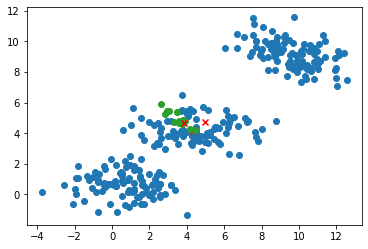

In [27]:
em = ExpectationMaximization(n_gaussian = 3)
em.fit(data, n_times=1, visualize=True, thr=1e-6)